### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import os

# ML tools
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Configuring plotting
from itertools import cycle

plt.style.use('fast')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

### Reading data using pandas

In [2]:
pwd = os.getcwd()
filepath = os.path.join(pwd,"rentals.csv")
house_df = pd.read_csv(filepath)
house_df.head()

,id,latitude,longitude,property_type,room_type,bathrooms,bedrooms,minimum_nights,price
0,958,37.76931,-122.43386,Apartment,Entire home/apt,1.0,1.0,1,$170.00
1,3850,37.75402,-122.45805,House,Private room,1.0,1.0,1,$99.00
2,5858,37.74511,-122.42102,Apartment,Entire home/apt,1.0,2.0,30,$235.00
3,7918,37.76669,-122.45250,Apartment,Private room,4.0,1.0,32,$65.00
4,8142,37.76487,-122.45183,Apartment,Private room,4.0,1.0,32,$65.00


### EDA

In [3]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8111 entries, 0 to 8110
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8111 non-null   int64  
 1   latitude        8111 non-null   float64
 2   longitude       8111 non-null   float64
 3   property_type   8111 non-null   object 
 4   room_type       8111 non-null   object 
 5   bathrooms       8099 non-null   float64
 6   bedrooms        8107 non-null   float64
 7   minimum_nights  8111 non-null   int64  
 8   price           8111 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 570.4+ KB


In [4]:
# Missing values
print(house_df.isnull().sum())

# Shape
print('\n')
print(f'Shape of the df: {house_df.shape}')

id                 0
latitude           0
longitude          0
property_type      0
room_type          0
bathrooms         12
bedrooms           4
minimum_nights     0
price              0
dtype: int64


Shape of the df: (8111, 9)


In [5]:
# Detecting outliers
house_df.describe()

,id,latitude,longitude,bathrooms,bedrooms,minimum_nights
count,8.111000e+03,8111.000000,8111.000000,8099.000000,8107.000000,8.111000e+03
mean,2.024561e+07,37.766054,-122.430107,1.395975,1.345874,1.234526e+04
std,1.228565e+07,0.022937,0.026967,0.923213,0.925298,1.110357e+06
min,9.580000e+02,37.704630,-122.513060,0.000000,0.000000,1.000000e+00
25%,8.905668e+06,37.751450,-122.442830,1.000000,1.000000,2.000000e+00
50%,2.161057e+07,37.769150,-122.424650,1.000000,1.000000,4.000000e+00
75%,3.120025e+07,37.785670,-122.410615,1.500000,2.000000,3.000000e+01
max,3.935418e+07,37.828790,-122.368570,14.000000,14.000000,1.000000e+08


It seems there're outliers in 'minimum_nights' and 'new_price' due to high standard deviation.
- 'minimum_nights' shouldn't be more than 1 year (365 days)

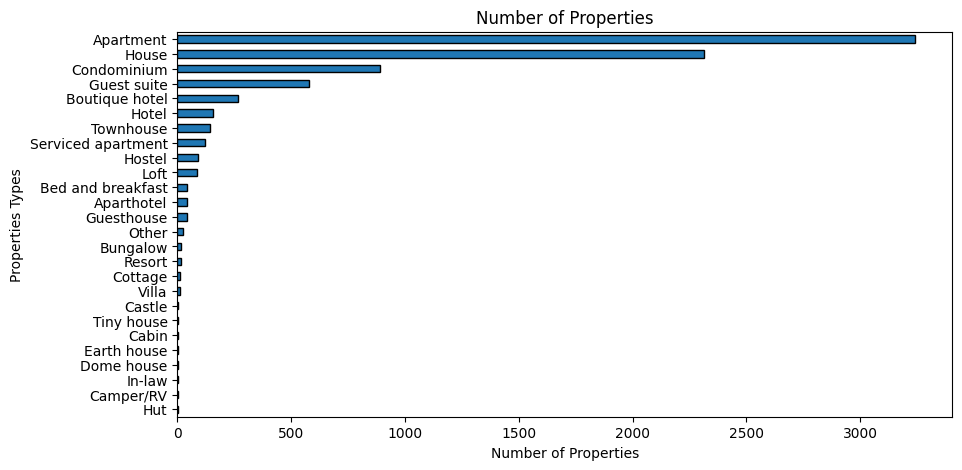

In [6]:
ax = house_df['property_type'].value_counts(ascending=True) \
    .plot(figsize=(10,5),kind='barh',
         title='Number of Properties',
         edgecolor='black')
ax.set_xlabel('Number of Properties')
ax.set_ylabel('Properties Types')
plt.show()

We can encompass these properties within 'Hostel':  'Bed and breakfast', 'Aparthotel', 'Guesthouse' 

### Cleaning Data and Processing Data

* features = latitude, longitude, propoerty_type, room_type, bathrooms, bedrooms, minimum_nights
* target = price

In [7]:
def preprocessing_house(house_df):
    '''This function clean the df'''
    # Correct '$' sign and make price column readable
    house_df['price'] = house_df['price'].str[1:-4].map(lambda x: x.replace(',', '').replace('.', '')).astype('int')
    
    # Drop unnecessary columns for ML
    house_df.drop('id', axis = 1, inplace = True)
    
    # We are going to guess there are 0 rooms/bathrooms when there is a missing value
    house_df.fillna(0, inplace= True)
    
    # Removing outliers
    house_df.drop(house_df[house_df.minimum_nights > 365].index, inplace = True)
    house_df.drop(house_df[house_df.price > 3000].index, inplace = True)
    
    # Removing unnusual properties
    house_df["property_type"].replace(
        to_replace=['Castle','Cabin','Tiny house','Earth house','In-law','Camper/RV','Dome house','Hut'],
        value='Other', inplace = True)        
    
    # Same with hostels
    house_df["property_type"].replace(
        to_replace=['Bed and breakfast', 'Aparthotel', 'Guesthouse'],
        value='Hostel', inplace = True)   
    return house_df

df = preprocessing_house(house_df)

In [8]:
def remove_outliers(df):
    # Customers to rent out their properties for short stays.
    # Removing outliers
    cols = ['minimum_nights','price'] # The columns you want to search for outliers in

    # Calculate quantiles and IQR
    Q1 = house_df[cols].quantile(0.25) # Same as np.percentile but maps (0,1) and not (0,100)
    Q3 = house_df[cols].quantile(0.75)
    IQR = Q3 - Q1

    # Return a boolean array of the rows with (any) non-outlier column values
    condition = ~((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

    # Filter our dataframe based on condition
    df = df[condition]
    
    return df

df_no_outliers = remove_outliers(df)

In [9]:
feature_cols = ['latitude', 'longitude','bathrooms', 'bedrooms', 'minimum_nights']

X = house_df[feature_cols]
y = house_df.price

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

linreg = LinearRegression()

linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

print (np.sqrt(mean_squared_error(y_test, y_pred)))

194.07825517765272


### Prepare data for ML

To make this funny, let's create 2 models:
* Baseline model: Cleaned and with outliers
* Model 1: Cleaned and without outliers

In [10]:
def get_X_y(dataframe):
    '''This function provides our X and y for ML'''
    X = dataframe.drop(['price'], axis=1)
    y = dataframe['price']
    
    return X, y

X_bl, y_bl = get_X_y(df)
X, y = get_X_y(df_no_outliers)

Setting up lazy but helpful tools from Scikit-learn

In [11]:
# set up preprocessing for numeric cols
imp_median = SimpleImputer(strategy='median')
scaler = StandardScaler()

# set up preprocessing for categorical cols
ohe = OneHotEncoder()

In [12]:
# select columns by data type
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_exclude='number')

In [13]:
# do all preprocessing
preprocessor = make_column_transformer(
    (make_pipeline(imp_median, scaler), num_cols),
    (make_pipeline(ohe),cat_cols)
)

### Linear Regression

In [14]:
def cross_validation(model, X, y):
    '''This function provides scoring for a determined model'''
    
    # create a pipeline
    pipe = make_pipeline(preprocessor, model)
    
    # use of built-in function cross_val_score from scikit-learn
    return cross_val_score(pipe, X, y).mean().round(2)

In [15]:
# Declare Linear Regression
lr = LinearRegression()

# cross-validate the pipeline
print(f'Cross-validation score for Baseline data (with outliers): {cross_validation(lr, X_bl, y_bl)}')
print(f'Cross-validation score (without outliers): {cross_validation(lr, X, y)}')

Cross-validation score for Baseline data (with outliers): 0.35
Cross-validation score (without outliers): 0.51


We can see that outliers are bad for our model

### Model selection

In [16]:
models = [LinearRegression(), DecisionTreeRegressor(random_state=42), RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=42)]
model_name = ["Linear Regression", "Tree Regressor", "RF Regressor", "Gradient Boost Regressor"]

In [17]:
def model_selection(X, y):
    '''This function returns scores for each model provided'''
    for name, model in zip(model_name, models):
        
        score = cross_validation(model, X, y)
        print("{} CV Score: {}".format(name, score))

In [18]:
# Model evaluation for Baseline
model_selection(X_bl, y_bl)

Linear Regression CV Score: 0.35
Tree Regressor CV Score: -0.04
RF Regressor CV Score: 0.41
Gradient Boost Regressor CV Score: 0.43


In [19]:
# Model evaluation without outliers
model_selection(X, y)

Linear Regression CV Score: 0.51
Tree Regressor CV Score: 0.22
RF Regressor CV Score: 0.54
Gradient Boost Regressor CV Score: 0.58


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.33, random_state=42)

In [21]:
pipe = make_pipeline(preprocessor, GradientBoostingRegressor(random_state=42))
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(pipe.score(X_test, y_test))

0.5909023273001863


### Hyperparameter tuning

In [ ]:
# In process...